# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)



In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import utils
pd.options.mode.chained_assignment = None  # default='warn'

import torch
tmpdir = tempfile.mkdtemp()


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

### Training set


**import data and get labels**

In [3]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [ ]:
# /content/drive/MyDrive/Colab Notebooks/data

In [ ]:
# train_path = '../data/train/'
# valid_path = '../data/valid/'

In [5]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [6]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
diagnosis = ['abnormal','meniscus','acl']

In [7]:
def get_data(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [13]:
# training data
train_coronal_men_data, train_coronal_men_dir, train_coronal_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_men_data, train_axial_men_dir, train_axial_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_men_data, train_sagittal_men_dir, train_sagittal_men_label = get_data('train', 'sagittal', 'meniscus')

In [14]:
# validation data
valid_coronal_men_data, valid_coronal_men_dir, valid_coronal_men_label = get_data('valid','coronal','meniscus')
valid_axial_men_data, valid_axial_men_dir, valid_axial_men_label = get_data('valid','axial','meniscus')
valid_sagittal_men_data, valid_sagittal_men_dir, valid_sagittal_men_label = get_data('valid','sagittal','meniscus')

**data generation**

In [18]:
# https://stackoverflow.com/questions/32171917/how-to-copy-a-2d-array-into-a-3rd-dimension-n-times
def augment(image):
    aug=[]
    for s in range(len(image)):
        # (resize is adapted for AlexNet (s x 277 x 277)
        aug.append(ia.imresize_single_image(image[s], (256, 256)))
#         aug.append(tf.image.resize(image, (277,277), method='bilinear'))
        
    aug = np.array(aug)
#     img_rehape = aug.reshape(277, 277, 1)
    # 3 means add color channel
    aug_reshape = np.repeat(aug[..., np.newaxis], 3, -1)

    return aug_reshape

In [19]:
# Create a data generator which will perform real-time data feeding to the Keras model.
# Generators do not store all the values in memory, they generate the values on the fly
def data_gen(data, label, path, data_length):
    all_data = list(zip(data,label))
    random.shuffle(all_data)
    i = 0
    while(True):
        if(i == data_length):
#             yield(None,None)
            break
        for pair in all_data:
#             if(pair[0] != '.DS_Store'):
            img = np.load(os.path.join(path,pair[0]),allow_pickle=True)
            img = img.astype(np.uint8)  # ensure data type range(0,255) before augmenting rgb
            img_aug = augment(img) # add data augment here
            yield(img_aug,np.repeat(pair[1],img_aug.shape[0]))
        i += 1

**data generation for meniscus**

In [22]:
# data generation for train - meniscus
coronal_meniscus = data_gen(train_coronal_men_data, train_coronal_men_label, train_coronal_men_dir, len(train_coronal_men_data))
axial_meniscus = data_gen(train_axial_men_data, train_axial_men_label, train_axial_men_dir, len(train_axial_men_data))
sagittal_meniscus = data_gen(train_sagittal_men_data, train_sagittal_men_label, train_sagittal_men_dir, len(train_sagittal_men_data))

# data generation for validation - meniscus
coronal_meniscus_val = data_gen(valid_coronal_men_data, valid_coronal_men_label, valid_coronal_men_dir, len(valid_coronal_men_data))
axial_meniscus_val = data_gen(valid_axial_men_data, valid_axial_men_label, valid_axial_men_dir, len(valid_axial_men_data))
sagittal_meniscus_val = data_gen(valid_sagittal_men_data, valid_sagittal_men_label, valid_sagittal_men_dir, len(valid_sagittal_men_data))

## Model building

**CNN**

The code snippet below is the first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun built in the 1990s for image classification (with the exception of ReLU). In addition, two fully-connected layers were added, and end with a single unit and a sigmoid activation, which is perfect for a binary classification. 

In [38]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

SGD was used with a learning rate of 0.001 (instead of default value=0.01), and momentum of 0.09 (instead of default value=0). Adding momentum hyperparameter is better because it helps to accelerate gradients vector in the right direction, so enabling faster converging. SGD also enables the use of the Nesterov accelerated gradient (default=False) which makes a correction if the gradient is accelerating too fast, and enables increased responsiveness to a local minima. Unfortunately, tuning the arguments in SGD will mean time required to use the GPU to assess the model. In the early stages, the loss and accuracy were fluctuating with each epoch. This could mean that the learning rate for SGD was too high, more data points were required, better normalisation should be done, or more fine-tuning of the hyperparameters were required (the last reason was not possible due to limited GPU access). 

In [39]:
# display architecture
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 57600)            

**predictions for abnormal dataset**

In [40]:
def plot_results(model):
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


In [41]:
def model_train(model, model_name, num_epochs, train_data, validation_data): 
    # path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    path_dir = '/content/drive/MyDrive' 
    path = f'{path_dir}/{model_name}/weights.h5'

    model = create_model()
    history = model.fit(train_data, 
                        batch_size=32, 
                        validation_data=validation_data,
                        epochs=num_epochs, 
                        steps_per_epoch = 1096,  # len/batch_size
                        validation_steps = 116,
                        callbacks = [EarlyStopping(patience=2, monitor = 'val_loss', mode = 'min')], 
                        verbose=1)
    
    model.save_weights(path)
    
    return model, history

steps_per_epoch is the the number of batch iterations before a training epoch is considered finished. It is used by calling the generator steps_per_epoch times. This needs to be specified since the dataset has dimensions 1130 x *s*, where *s* is the number of slides and ranges from 17-61 (from EDA). If this parameter is left out, the size is 'unknown', and it runs infinitely. Since I do not have the time to run through my entire dataset, I set this to about 1000. Setting at the length of the dataset of 1130 resulted in no changes to loss and accuracy. Setting it to 1096 (a little below 1130) showed *some* changes. A smaller number and the loss and accuracy fluctuates heavily. This is similar to validation_steps.
<br>
<br> batch_size was also another approximation. It seems that a larger batch may result in degradation of the quality of the model, since the model lacks the ability to generalise the dataset. 


**predictions for meniscus dataset**

Epoch 1/10
1096/1096 [==============================] - 96s 87ms/step - loss: 1.5832 - accuracy: 0.6354 - val_loss: 0.6749 - val_accuracy: 0.5954
Epoch 2/10
1096/1096 [==============================] - 95s 86ms/step - loss: 0.6572 - accuracy: 0.6449 - val_loss: 0.6836 - val_accuracy: 0.5924
Epoch 3/10
1096/1096 [==============================] - 94s 86ms/step - loss: 0.6555 - accuracy: 0.6389 - val_loss: 0.6744 - val_accuracy: 0.5993
Epoch 4/10
1096/1096 [==============================] - 94s 86ms/step - loss: 0.6488 - accuracy: 0.6429 - val_loss: 0.6778 - val_accuracy: 0.5845
Epoch 5/10
1096/1096 [==============================] - 94s 86ms/step - loss: 0.6437 - accuracy: 0.6420 - val_loss: 0.6766 - val_accuracy: 0.5907


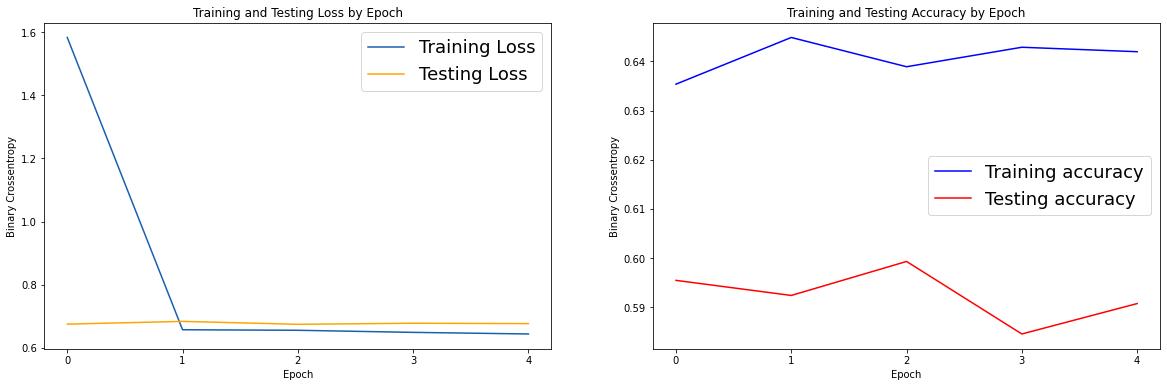

In [42]:
num_epochs = 10
cnn_model = create_model()
hst_cmen_model, hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_meniscus, coronal_meniscus_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/10
1096/1096 [==============================] - 113s 103ms/step - loss: 1.1249 - accuracy: 0.6321 - val_loss: 0.6835 - val_accuracy: 0.5815
Epoch 2/10
1096/1096 [==============================] - 106s 97ms/step - loss: 0.6608 - accuracy: 0.6432 - val_loss: 0.6867 - val_accuracy: 0.5706
Epoch 3/10
1096/1096 [==============================] - 106s 97ms/step - loss: 0.6554 - accuracy: 0.6432 - val_loss: 0.6840 - val_accuracy: 0.5781


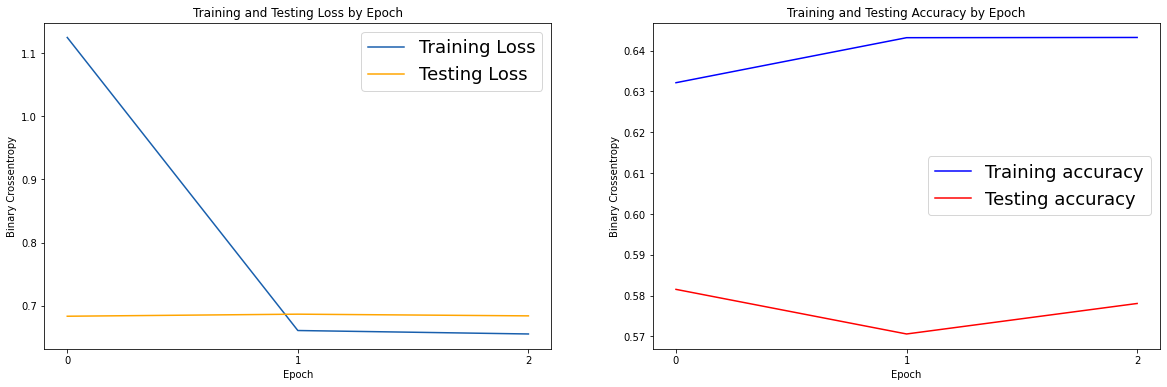

In [43]:
num_epochs = 10
cnn_model = create_model()
hst_amen_model, hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_meniscus, axial_meniscus_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
plot_results(hst_amen)

Epoch 1/10
1096/1096 [==============================] - 99s 90ms/step - loss: 1.4332 - accuracy: 0.6363 - val_loss: 0.6774 - val_accuracy: 0.5968
Epoch 2/10
1096/1096 [==============================] - 96s 87ms/step - loss: 0.6634 - accuracy: 0.6404 - val_loss: 0.6831 - val_accuracy: 0.5877
Epoch 3/10
1096/1096 [==============================] - 95s 87ms/step - loss: 0.6565 - accuracy: 0.6424 - val_loss: 0.6809 - val_accuracy: 0.5840


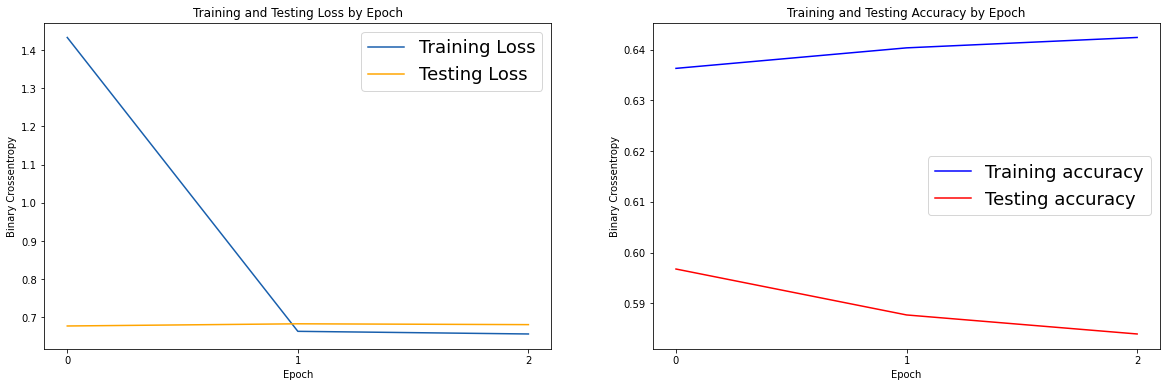

In [44]:
num_epochs = 10
cnn_model = create_model()
hst_smen_model, hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_meniscus, sagittal_meniscus_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
plot_results(hst_smen)